In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
 
# Sci-kit learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
# import data
 
reg_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTg36jLawSOgGP9hp0oJ3OYZiHMWbuGLiau-8DMjtcKNv7v9Zy_zFBQs9gZU-44GGeIyfXE2iwo26_z/pub?output=csv'
df_reg = pd.read_csv(reg_url)
 
# drop car name columns
df_reg = df_reg.drop(columns='car name')
 
df_reg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [5]:
# check missing values and duplicates
print('\nmissing values', df_reg.info())
print('duplicated rows', df_reg.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 24.6 KB

missing values None
duplicated rows 0


In [6]:
# split data
 
X = df_reg.drop(columns='mpg')
y = df_reg['mpg']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [7]:
# lists of columns for transformer
cat_cols = ['cylinders','model year','origin']
num_cols = X_train.columns.drop(cat_cols)

# PREPROCESSING PIPELINE FOR NUMERIC DATA

# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)


# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA

# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, cat_cols)

# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)

# Fit and transform the training data
X_train_tf = col_transformer.fit_transform(X_train)
# Transform the testing data
X_test_tf = col_transformer.transform(X_test)
# View the processed training data
X_train_tf.head()

,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model year_70,...,model year_76,model year_77,model year_78,model year_79,model year_80,model year_81,model year_82,origin_1,origin_2,origin_3
265,-0.588476,-0.245826,-0.490076,-0.458303,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16,0.033663,-0.193925,-0.235417,-0.002504,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66,2.235078,2.686610,1.976787,-1.580270,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
158,0.339946,0.143435,1.112849,1.925875,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,2.340363,2.868265,1.594798,-2.456806,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
# Define shape
input_shape = X_train_tf.shape[1]
input_shape

25

In [9]:
# Build regression model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(10, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(10, 
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [10]:
# Call our build function to build model
reg_model = build_model()

# Get model summary
reg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                260       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [12]:
history = reg_model.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])

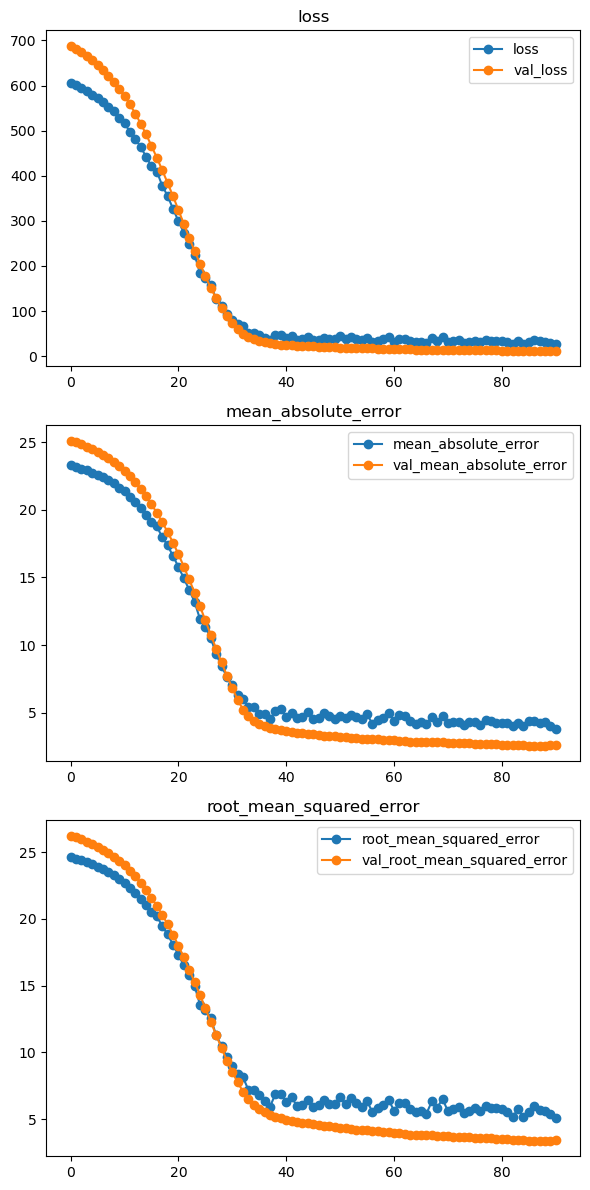

In [13]:
# plot learning 
plot_history(history);

In [14]:
# evaluate model
y_pred = reg_model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

4/4 [==============================] - 0s 2ms/step
final RMSE: 2.8592000622755354
final MAE: 2.2021710317962024
final R2: 0.8379036186301699
